In [1]:
# import dependencies
import scanpy as sc
import pandas as pd
import numpy as np
import os
import loompy as lp
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
sc.settings.set_figure_params(dpi = 50, dpi_save = 600, figsize = (4, 4))

/public/home/zhaox/anaconda3/envs/pyscenic/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/public/home/zhaox/anaconda3/envs/pyscenic/lib/python3.10/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/public/home/zhaox/anaconda3/envs/pyscenic/lib/python3.10/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied

In [2]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/public/home/zhaox/pigscRNA-seq/"
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "neospg_unfiltered.loom" 

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "neospg_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "neospg_anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "neospg_pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'neospg_scenic_integrated-output.loom'

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 5

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 9.5.0
asttokens           NA
backcall            0.2.0
cloudpickle         2.2.1
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.1
dask                2023.4.1
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
executing           1.2.0
h5py                3.8.0
ipykernel           6.22.0
jedi                0.18.2
jinja2              3.1.2
joblib              1.2.0
kiwisolver          1.4.4
llvmlite            0.40.0
loompy              3.0.7
lz4                 4.3.2
markupsafe          2.1.2
matplotlib          3.7.1
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.3.1
numba               0.57.0
numexpr             2.8.4
numpy               1.21.2
numpy_groupies      0.9.20
packaging           23.1
pandas              1.5.3
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources  

In [13]:
adata = sc.read('/public/home/zhaox/pigscRNA-seq/figures/neospg_annotation.h5ad') 
adata

AnnData object with n_obs × n_vars = 184 × 4944
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
adata.obs['cell_type']

AAAGGGCAGGCTAGCA-1         SSC
AACAAGACACCTGTCT-1         SSC
AACCACATCACTTCTA-1    PreSPG-1
AAGACTCCAACACTAC-1         SSC
AAGACTCCACTGCATA-1    PreSPG-1
                        ...   
TTCCGTGGTCGTTTCC-1    PreSPG-1
TTCTTCCCAGACTCTA-1         SSC
TTGCGTCGTACTTGTG-1         SSC
TTGGGCGGTCACTGAT-1         SSC
TTTAGTCAGCGTGCCT-1         SSC
Name: cell_type, Length: 184, dtype: category
Categories (3, object): ['PreSPG-1', 'PreSPG-2', 'SSC']

In [5]:
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 184 × 19204
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrX', 'chrY', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 6222 genes that are detected in less than 3 cells


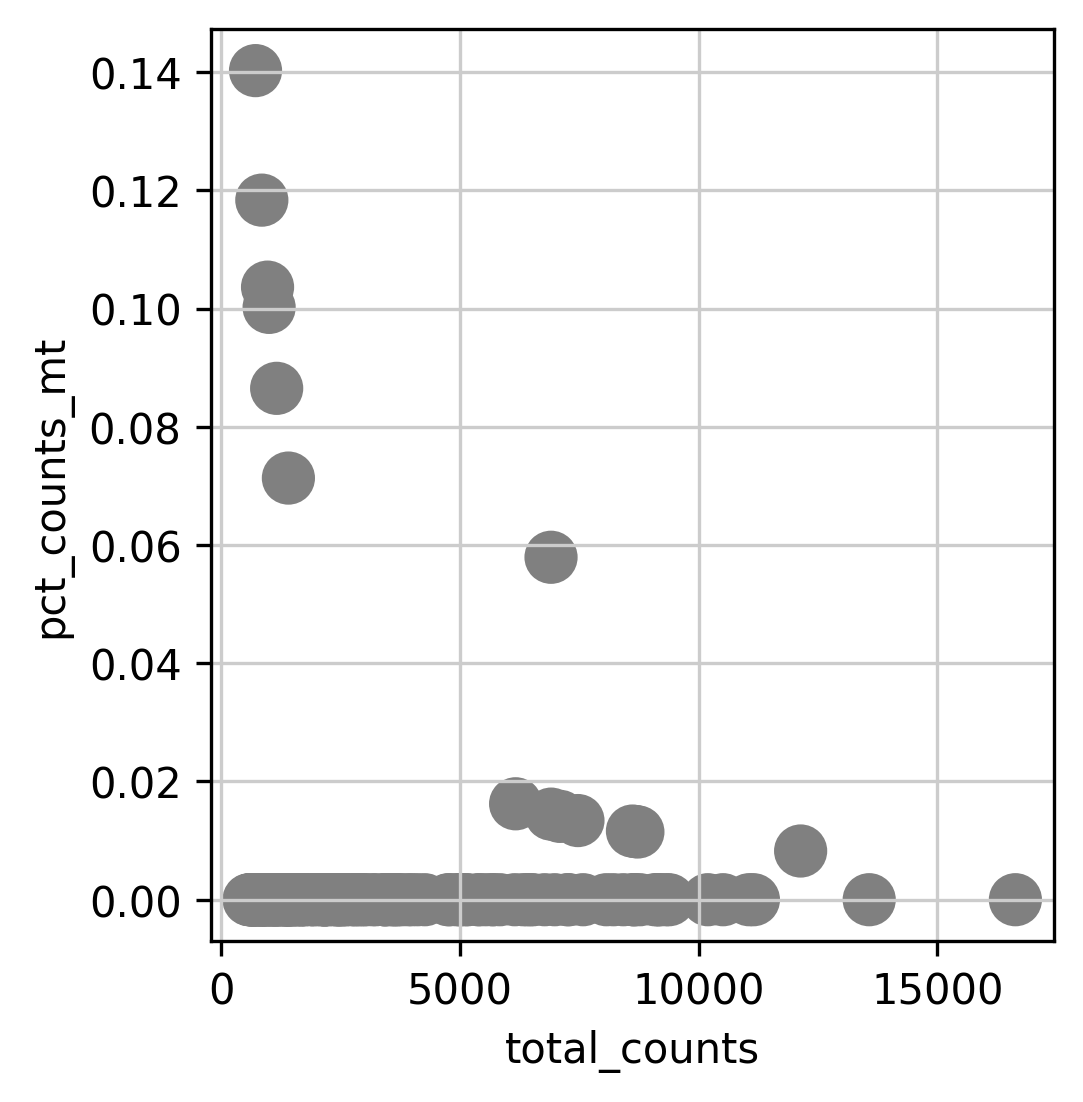

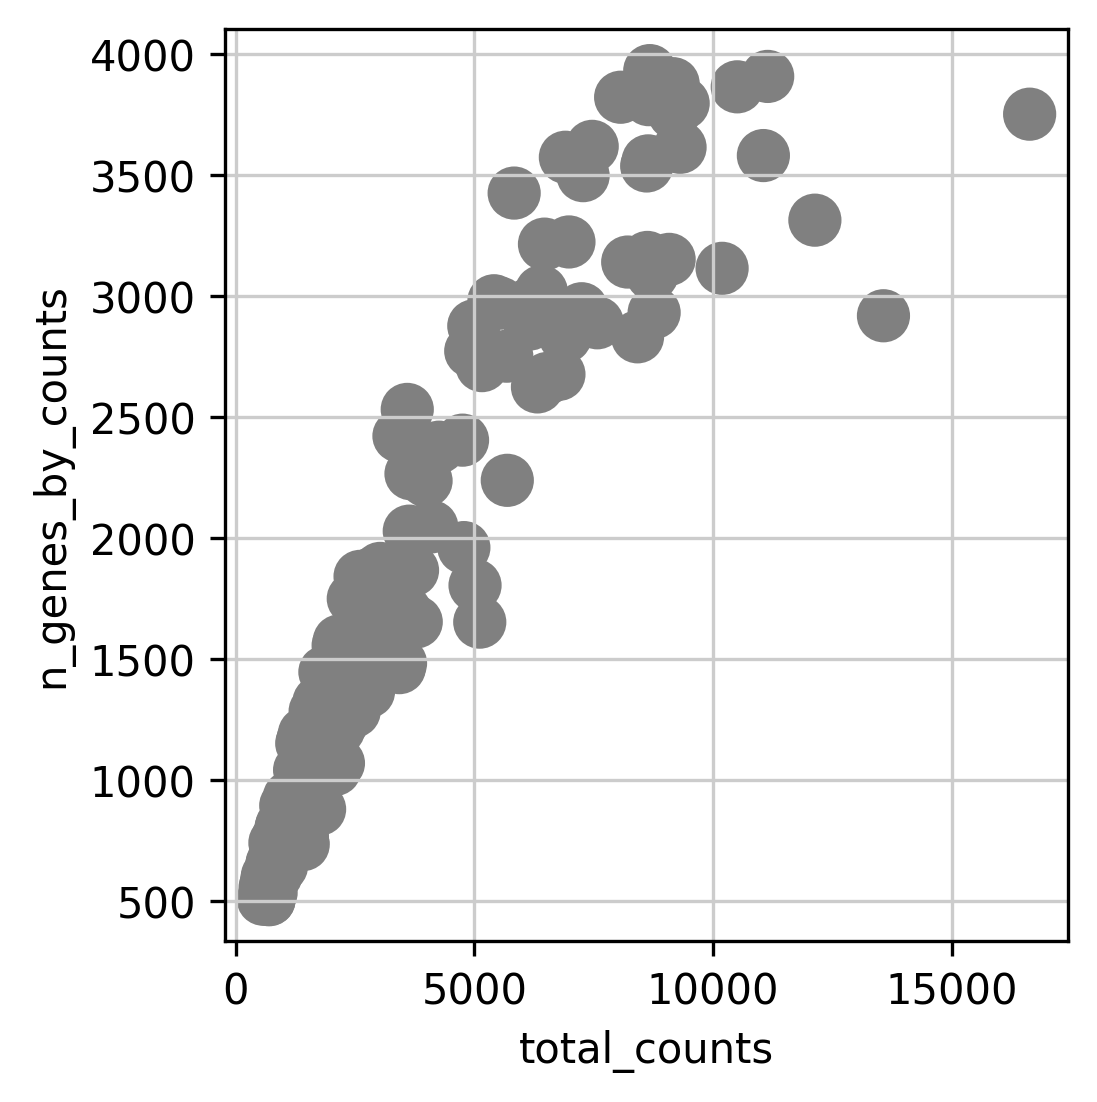

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [9]:
adata = adata[adata.obs.n_genes_by_counts < 4000, :]

In [10]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

In [12]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect('/public/home/zhaox/pigscRNA-seq/neo_aucell_scenic.loom', mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [2]:
from pathlib import Path
import operator
import cytoolz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from pyscenic.utils import load_motifs
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.plotting import plot_binarization, plot_rss
from pyscenic.transform import df2regulons

In [3]:
# helper functions (not yet integrated into pySCENIC):

from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [26]:
def display_logos(df: pd.DataFrame,
                   top_target_genes: int = 3, 
                   base_url: str = "http://motifcollections.aertslab.org/v10/logos/"
                   ,column_name_logo = "MotifLogo"
                   ,column_name_id  = "MotifID"
                   , column_name_target = "TargetGenes"
                   ):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", column_name_logo)] = list(map(create_url, df.index.get_level_values(column_name_id)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", column_name_target)] = list(map(truncate, df[("Enrichment", column_name_target)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', -1)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [16]:
auc_mtx

,AEBP2(+),ALX3(+),AR(+),ARNT2(+),ASCL1(+),ATF1(+),ATF2(+),ATF3(+),ATF6(+),ATF6B(+),...,ZNF311(+),ZNF317(+),ZNF432(+),ZNF444(+),ZNF536(+),ZNF605(+),ZNF654(+),ZNF664(+),ZNF76(+),ZNF84(+)
AAAGGGCAGGCTAGCA-1,0.015922,0.000000,0.000000,0.038575,0.010863,0.018661,0.019612,0.065733,0.015813,0.030597,...,0.000000,0.0,0.11094,0.000000,0.087982,0.031012,0.083398,0.006824,0.024863,0.053726
AACAAGACACCTGTCT-1,0.017463,0.000000,0.000000,0.004568,0.024823,0.000000,0.022656,0.033210,0.020666,0.000000,...,0.002883,0.0,0.00000,0.000000,0.000000,0.045027,0.078582,0.000000,0.000000,0.043143
AACCACATCACTTCTA-1,0.059322,0.000000,0.000000,0.010948,0.017704,0.061462,0.030798,0.091508,0.024615,0.000000,...,0.005915,0.0,0.00000,0.014988,0.000000,0.009221,0.000000,0.011270,0.000000,0.058430
AAGACTCCAACACTAC-1,0.161274,0.013046,0.000000,0.007339,0.005347,0.000000,0.014933,0.025369,0.019203,0.000000,...,0.000000,0.0,0.00000,0.000000,0.076888,0.012645,0.000000,0.017477,0.000000,0.105871
AAGACTCCACTGCATA-1,0.000000,0.000000,0.000000,0.011725,0.007797,0.020031,0.026099,0.031085,0.034707,0.000000,...,0.000000,0.0,0.00000,0.049867,0.000000,0.011666,0.000000,0.005063,0.000000,0.035804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCGTGGTCGTTTCC-1,0.000000,0.001164,0.000000,0.003156,0.003698,0.000000,0.015637,0.030844,0.017700,0.000000,...,0.011929,0.0,0.00000,0.000000,0.000000,0.012596,0.000000,0.000000,0.000000,0.009245
TTCTTCCCAGACTCTA-1,0.043914,0.000000,0.000000,0.002751,0.004253,0.000000,0.028762,0.022707,0.023806,0.000000,...,0.000000,0.0,0.00000,0.012047,0.000000,0.005430,0.026579,0.012547,0.000000,0.035236
TTGCGTCGTACTTGTG-1,0.000000,0.000000,0.000000,0.013415,0.005994,0.000000,0.013944,0.018744,0.034784,0.000000,...,0.000000,0.0,0.00000,0.000000,0.026194,0.007949,0.045647,0.000000,0.008124,0.040021
TTGGGCGGTCACTGAT-1,0.093220,0.000000,0.000000,0.009387,0.001310,0.000000,0.016797,0.021799,0.013193,0.000000,...,0.000000,0.0,0.00000,0.000000,0.078582,0.057622,0.004237,0.013559,0.000000,0.040386


In [17]:
bin_mtx, thresholds = binarize(auc_mtx,seed=1314,num_workers=12)

In [18]:
bin_mtx.to_csv("/public/home/zhaox/pigscRNA-seq/neo_bin_mtx.csv")
thresholds.to_frame().rename(columns={0:'threshold'}).to_csv("/public/home/zhaox/pigscRNA-seq/neo_thresholds.csv")

In [19]:
bin_mtx = pd.read_csv("/public/home/zhaox/pigscRNA-seq/neo_bin_mtx.csv", index_col=0)
thresholds = pd.read_csv("/public/home/zhaox/pigscRNA-seq/neo_thresholds.csv", index_col=0).threshold

/public/home/zhaox/anaconda3/envs/pyscenic/lib/python3.10/site-packages/pyscenic/plotting.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_mtx[regulon_name], ax=ax, norm_hist=True, bins=bins)
/public/home/zhaox/anaconda3/envs/pyscenic/lib/python3.10/site-packages/pyscenic/plotting.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de

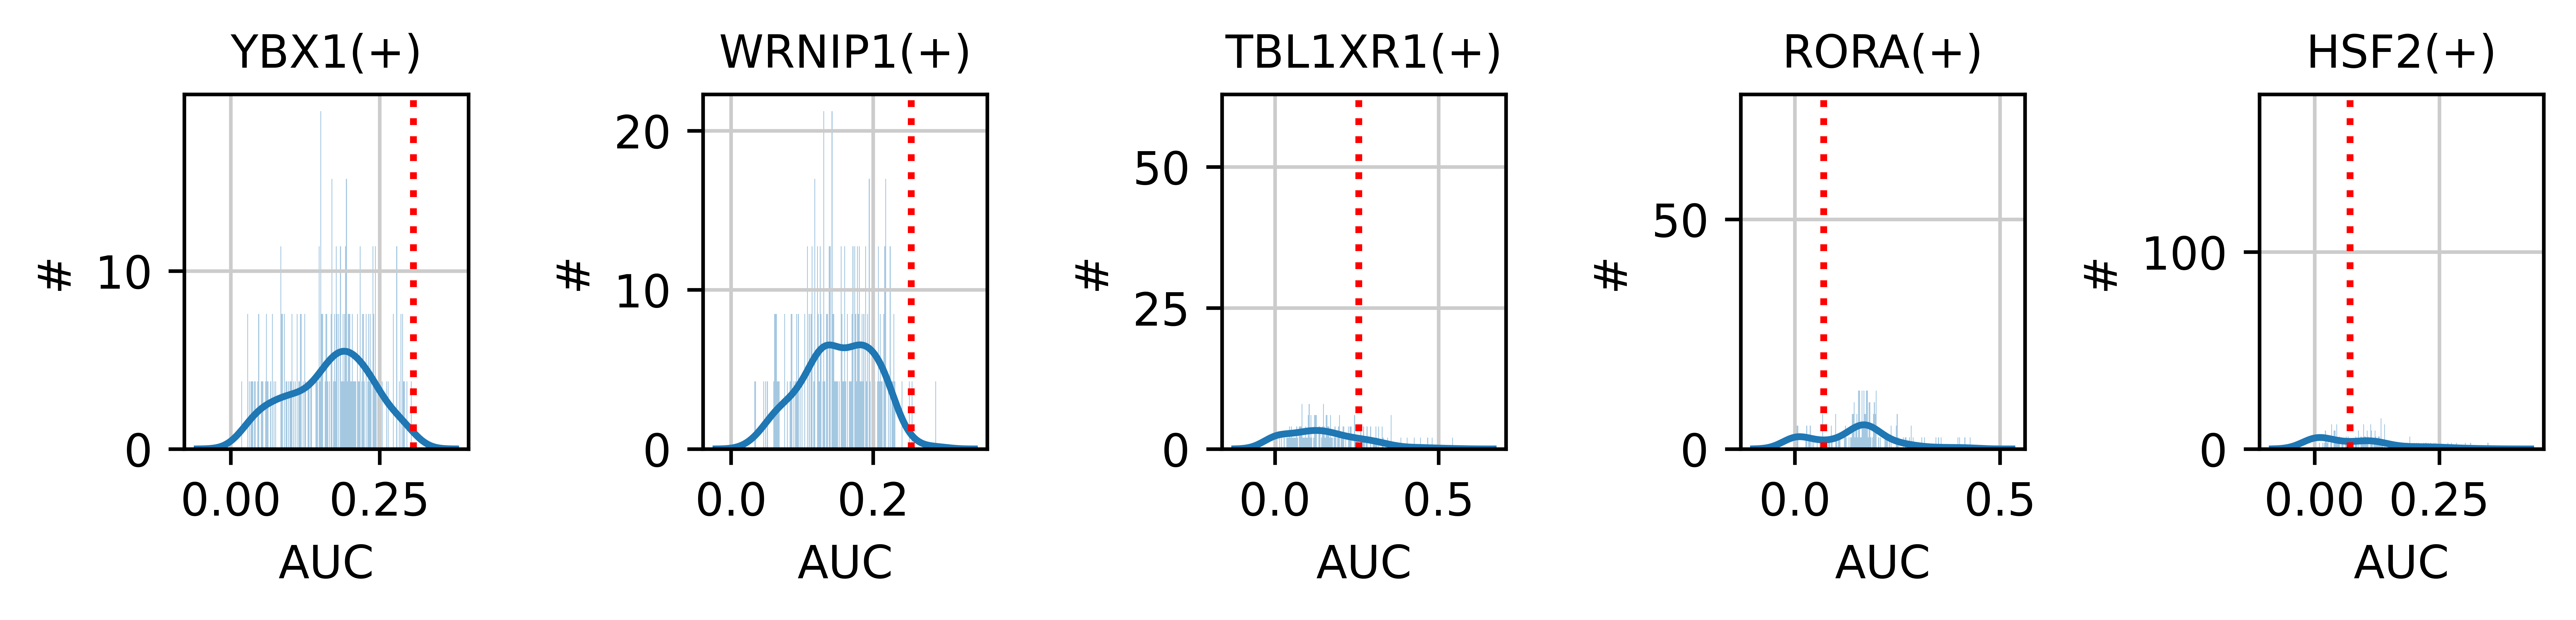

In [20]:
auc_sum = auc_mtx.apply(sum,axis=0).sort_values(ascending=False)
fig, axes = plt.subplots(1, 5, figsize=(8, 2), dpi=600)
for x,y in enumerate(axes):
    plot_binarization(auc_mtx, auc_sum.index[x], thresholds[auc_sum.index[x]], ax=y)
plt.tight_layout()
plt.savefig("/public/home/zhaox/pigscRNA-seq/neo_auc_binarization0505.pdf")

In [21]:
### We can also add all metadata derived from SCENIC to the scanpy.AnnData object.
# load the regulons from a file using the load_signatures function
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
sig = load_signatures('/public/home/zhaox/pigscRNA-seq/neo_reg.csv')
adata = add_scenic_metadata(adata, auc_mtx, sig)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [4]:
df_motifs = load_motifs('/public/home/zhaox/pigscRNA-seq/neo_reg.csv')
df_motifs

Enrichment             
                                                  AUC       NES   
TF     MotifID                                                    
ALX3   taipale__UNCX_DBD_NTAATYTAATTAN       0.048796  3.100471  \
       cisbp__M5941                          0.047975  3.013918   
ARNT2  homer__TCACGTGAYH_Cbf1                0.058237  3.275964   
       transfac_pro__M01794                  0.057908  3.231174   
       transfac_pro__M00985                  0.060778  3.621861   
...                                               ...       ...   
ZNF263 factorbook__ZNF263                    0.053744  3.101975   
       homer__CNGTCCTCCC_Znf263              0.053225  3.032155   
       hocomoco__ZN263_HUMAN.H11MO.1.A       0.059465  3.871784   
       dbcorrdb__ZNF263__ENCSR000EVD_1__m1   0.064727  4.579927   
ZNF84  dbcorrdb__BRF2__ENCSR000DNV_1__m2     0.063651  3.384250   

                                                                   
                                           MotifSimilarityQvalue   
TF     MotifID                                                     
ALX3   taipale__UNCX_DBD_NTAATYTAATTAN                  0.000002  \
       cisbp__M5941                                     0.000001   
ARNT2  homer__TCACGTGAYH_Cbf1                           0.000969   
       transfac_pro__M01794                             0.000549   
       transfac_pro__M00985                             0.000471   
...                                                          ...   
ZNF263 factorbook__ZNF263                               0.000000   
       homer__CNGTCCTCCC_Znf263                         0.000000   
       hocomoco__ZN263_HUMAN.H11MO.1.A                  0.000000   
       dbcorrdb__ZNF263__ENCSR000EVD_1__m1              0.000000   
ZNF84  dbcorrdb__BRF2__ENCSR000DNV_1__m2                0.000441   

                                                                 
                                           OrthologousIdentity   
TF     MotifID                                                   
ALX3   taipale__UNCX_DBD_NTAATYTAATTAN                1.000000  \
       cisbp__M5941                                   1.000000   
ARNT2  homer__TCACGTGAYH_Cbf1                         0.462617   
       transfac_pro__M01794                           0.414226   
       transfac_pro__M00985                           1.000000   
...                                                        ...   
ZNF263 factorbook__ZNF263                             1.000000   
       homer__CNGTCCTCCC_Znf263                       1.000000   
       hocomoco__ZN263_HUMAN.H11MO.1.A                1.000000   
       dbcorrdb__ZNF263__ENCSR000EVD_1__m1            1.000000   
ZNF84  dbcorrdb__BRF2__ENCSR000DNV_1__m2              0.256757   

                                                                                                
                                                                                   Annotation   
TF     MotifID                                                                                  
ALX3   taipale__UNCX_DBD_NTAATYTAATTAN      motif similar to hocomoco__ALX3_HUMAN.H11MO.0....  \
       cisbp__M5941                         motif similar to hocomoco__ALX3_HUMAN.H11MO.0....   
ARNT2  homer__TCACGTGAYH_Cbf1               motif similar to flyfactorsurvey__tgo_cyc_SANG...   
       transfac_pro__M01794                 gene is orthologous to FBgn0264075 in D. melan...   
       transfac_pro__M00985                 gene is annotated for similar motif taipale_cy...   
...                                                                                       ...   
ZNF263 factorbook__ZNF263                                          gene is directly annotated   
       homer__CNGTCCTCCC_Znf263                                    gene is directly annotated   
       hocomoco__ZN263_HUMAN.H11MO.1.A                             gene is directly annotated   
       dbcorrdb__ZNF263__ENCSR000EVD_1__m1                    

In [5]:
selected_motifs = ['ETV5','POLE3','JUND','KLF2','KLF5','MYBL1']
df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]
df_motifs_sel

Enrichment             
                                                                AUC       NES   
TF    MotifID                                                                   
ETV5  transfac_pro__M07415                                 0.066886  4.715489  \
      dbcorrdb__POLR2A__ENCSR000EHP_1__m1                  0.077048  5.819122   
      hdpi__ETV4                                           0.074315  5.522286   
      cisbp__M1891                                         0.068207  4.858893   
      jaspar__MA0062.2                                     0.067268  4.756994   
...                                                             ...       ...   
      transfac_pro__M02059                                 0.064121  5.242441   
      taipale_cyt_meth__ETV2_NRCCGGAAGTN_eDBD              0.056707  4.223663   
      cisbp__M5384                                         0.062988  5.086830   
KLF2  taipale_cyt_meth__KLF11_NMCACGCCCNNNNCACGCCCMC_...   0.060846  3.142571   
MYBL1 cisbp__M1355                                         0.055295  3.052688   

                                                                                 
                                                         MotifSimilarityQvalue   
TF    MotifID                                                                    
ETV5  transfac_pro__M07415                                            0.000996  \
      dbcorrdb__POLR2A__ENCSR000EHP_1__m1                             0.000990   
      hdpi__ETV4                                                      0.000984   
      cisbp__M1891                                                    0.000858   
      jaspar__MA0062.2                                                0.000848   
...                                                                        ...   
      transfac_pro__M02059                                            0.000000   
      taipale_cyt_meth__ETV2_NRCCGGAAGTN_eDBD                         0.000000   
      cisbp__M5384                                                    0.000000   
KLF2  taipale_cyt_meth__KLF11_NMCACGCCCNNNNCACGCCCMC_...              0.000044   
MYBL1 cisbp__M1355                                                    0.000381   

                                                                               
                                                         OrthologousIdentity   
TF    MotifID                                                                  
ETV5  transfac_pro__M07415                                          0.954902  \
      dbcorrdb__POLR2A__ENCSR000EHP_1__m1                           1.000000   
      hdpi__ETV4                                                    1.000000   
      cisbp__M1891                                                  0.298039   
      jaspar__MA0062.2                                              0.298039   
...                                                                      ...   
      transfac_pro__M02059                                          1.000000   
      taipale_cyt_meth__ETV2_NRCCGGAAGTN_eDBD                       1.000000   
      cisbp__M5384                                                  1.000000   
KLF2  taipale_cyt_meth__KLF11_NMCACGCCCNNNNCACGCCCMC_...            1.000000   
MYBL1 cisbp__M1355                                                  0.924202   

                                                                                                              
                                                                                                 Annotation   
TF    MotifID                                                                                                 
ETV5  transfac_pro__M07415                                gene is orthologous to ENSMUSG00000013089 in M...  \
      dbcorrdb__POLR2A__ENCSR000EHP_1__m1                 motif similar to taipale_cyt_meth__ETV5_NRCCGG...   
      hdpi__ETV4                                          gene is annotated for similar motif cis

In [6]:
#display_logos(df_motifs.head())
motiflogo = display_logos(df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False))
motiflogo

In [11]:
##'ETV5','POLE3','JUND','KLF2','KLF5','MYBL1'
selected_motifs = ['KLF2','MYBL1']
df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]
## display_logos(df_motifs_sel.sort_values([('Enrichment','NES')]))
display_logos(df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False))

In [23]:
adata

AnnData object with n_obs × n_vars = 184 × 4944
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_chrX', 'pct_counts_chrX', 'total_counts_chrY', 'pct_counts_chrY', 'S_score', 'G2M_score', 'phase', 'doublet', 'doublet_score', 'leiden', 'cell_type', 'Regulon(AEBP2(+))', 'Regulon(ALX3(+))', 'Regulon(AR(+))', 'Regulon(ARNT2(+))', 'Regulon(ASCL1(+))', 'Regulon(ATF1(+))', 'Regulon(ATF2(+))', 'Regulon(ATF3(+))', 'Regulon(ATF6(+))', 'Regulon(ATF6B(+))', 'Regulon(BACH1(+))', 'Regulon(BATF3(+))', 'Regulon(BCL11A(+))', 'Regulon(BCLAF1(+))', 'Regulon(BHLHE40(+))', 'Regulon(BHLHE41(+))', 'Regulon(BRF1(+))', 'Regulon(BRF2(+))', 'Regulon(CDX4(+))', 'Regulon(CEBPD(+))', 'Regulon(CEBPG(+))', 'Regulon(CHD1(+))', 'Regulon(CREB1(+))', 'Regulon(CREB3(+))', 'Regulon(CREB3L4(+))', 'Regulon(CREBL2(+))', 'Regulon(CREM(+))', 'Regulon(CTCF(+))', 'Regulon(CTCFL(+))', 'Regulon(CUX1(+))', 'Regulon(CUX2(+))', 'Regulon(CXXC1(+))', 'Regulon(DBP(+))', 'Regulon(DD

In [24]:
selected_motifs = ['ETV5','E2F1','YBX1']
df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [28]:
def fetch_logo(regulon, base_url = "http://motifcollections.aertslab.org/v10/logos/"):
    for elem in regulon.context:
        if elem.endswith('.png'):
            return '<img src="{}{}" style="max-height:124px;"></img>'.format(base_url, elem)
    return ""

In [29]:
import operator as op
#display_logos(df_motifs.head())
display_logos(df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

/tmp/ipykernel_95470/1009801328.py:26: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


NameError: name 'HTML' is not defined

In [30]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [31]:
rss_cellType = regulon_specificity_scores(auc_mtx, adata.obs['cell_type'] )
rss_cellType

,AEBP2(+),ALX3(+),AR(+),ARNT2(+),ASCL1(+),ATF1(+),ATF2(+),ATF3(+),ATF6(+),ATF6B(+),...,ZNF311(+),ZNF317(+),ZNF432(+),ZNF444(+),ZNF536(+),ZNF605(+),ZNF654(+),ZNF664(+),ZNF76(+),ZNF84(+)
SSC,0.452400,0.269670,0.268903,0.588651,0.459446,0.411721,0.446940,0.460478,0.517194,0.234566,...,0.281378,0.272628,0.264575,0.242030,0.443588,0.532797,0.525216,0.381485,0.308517,0.564728
PreSPG-1,0.223336,0.264519,0.198044,0.327341,0.345313,0.251834,0.379997,0.354971,0.371095,0.201570,...,0.204936,0.222949,0.192329,0.302205,0.301598,0.312559,0.212950,0.290745,0.209756,0.355097
PreSPG-2,0.249582,0.250655,0.393242,0.288546,0.293072,0.258431,0.416603,0.459986,0.358364,0.210690,...,0.204024,0.331392,0.313148,0.234860,0.252419,0.296605,0.240378,0.327888,0.256487,0.314948


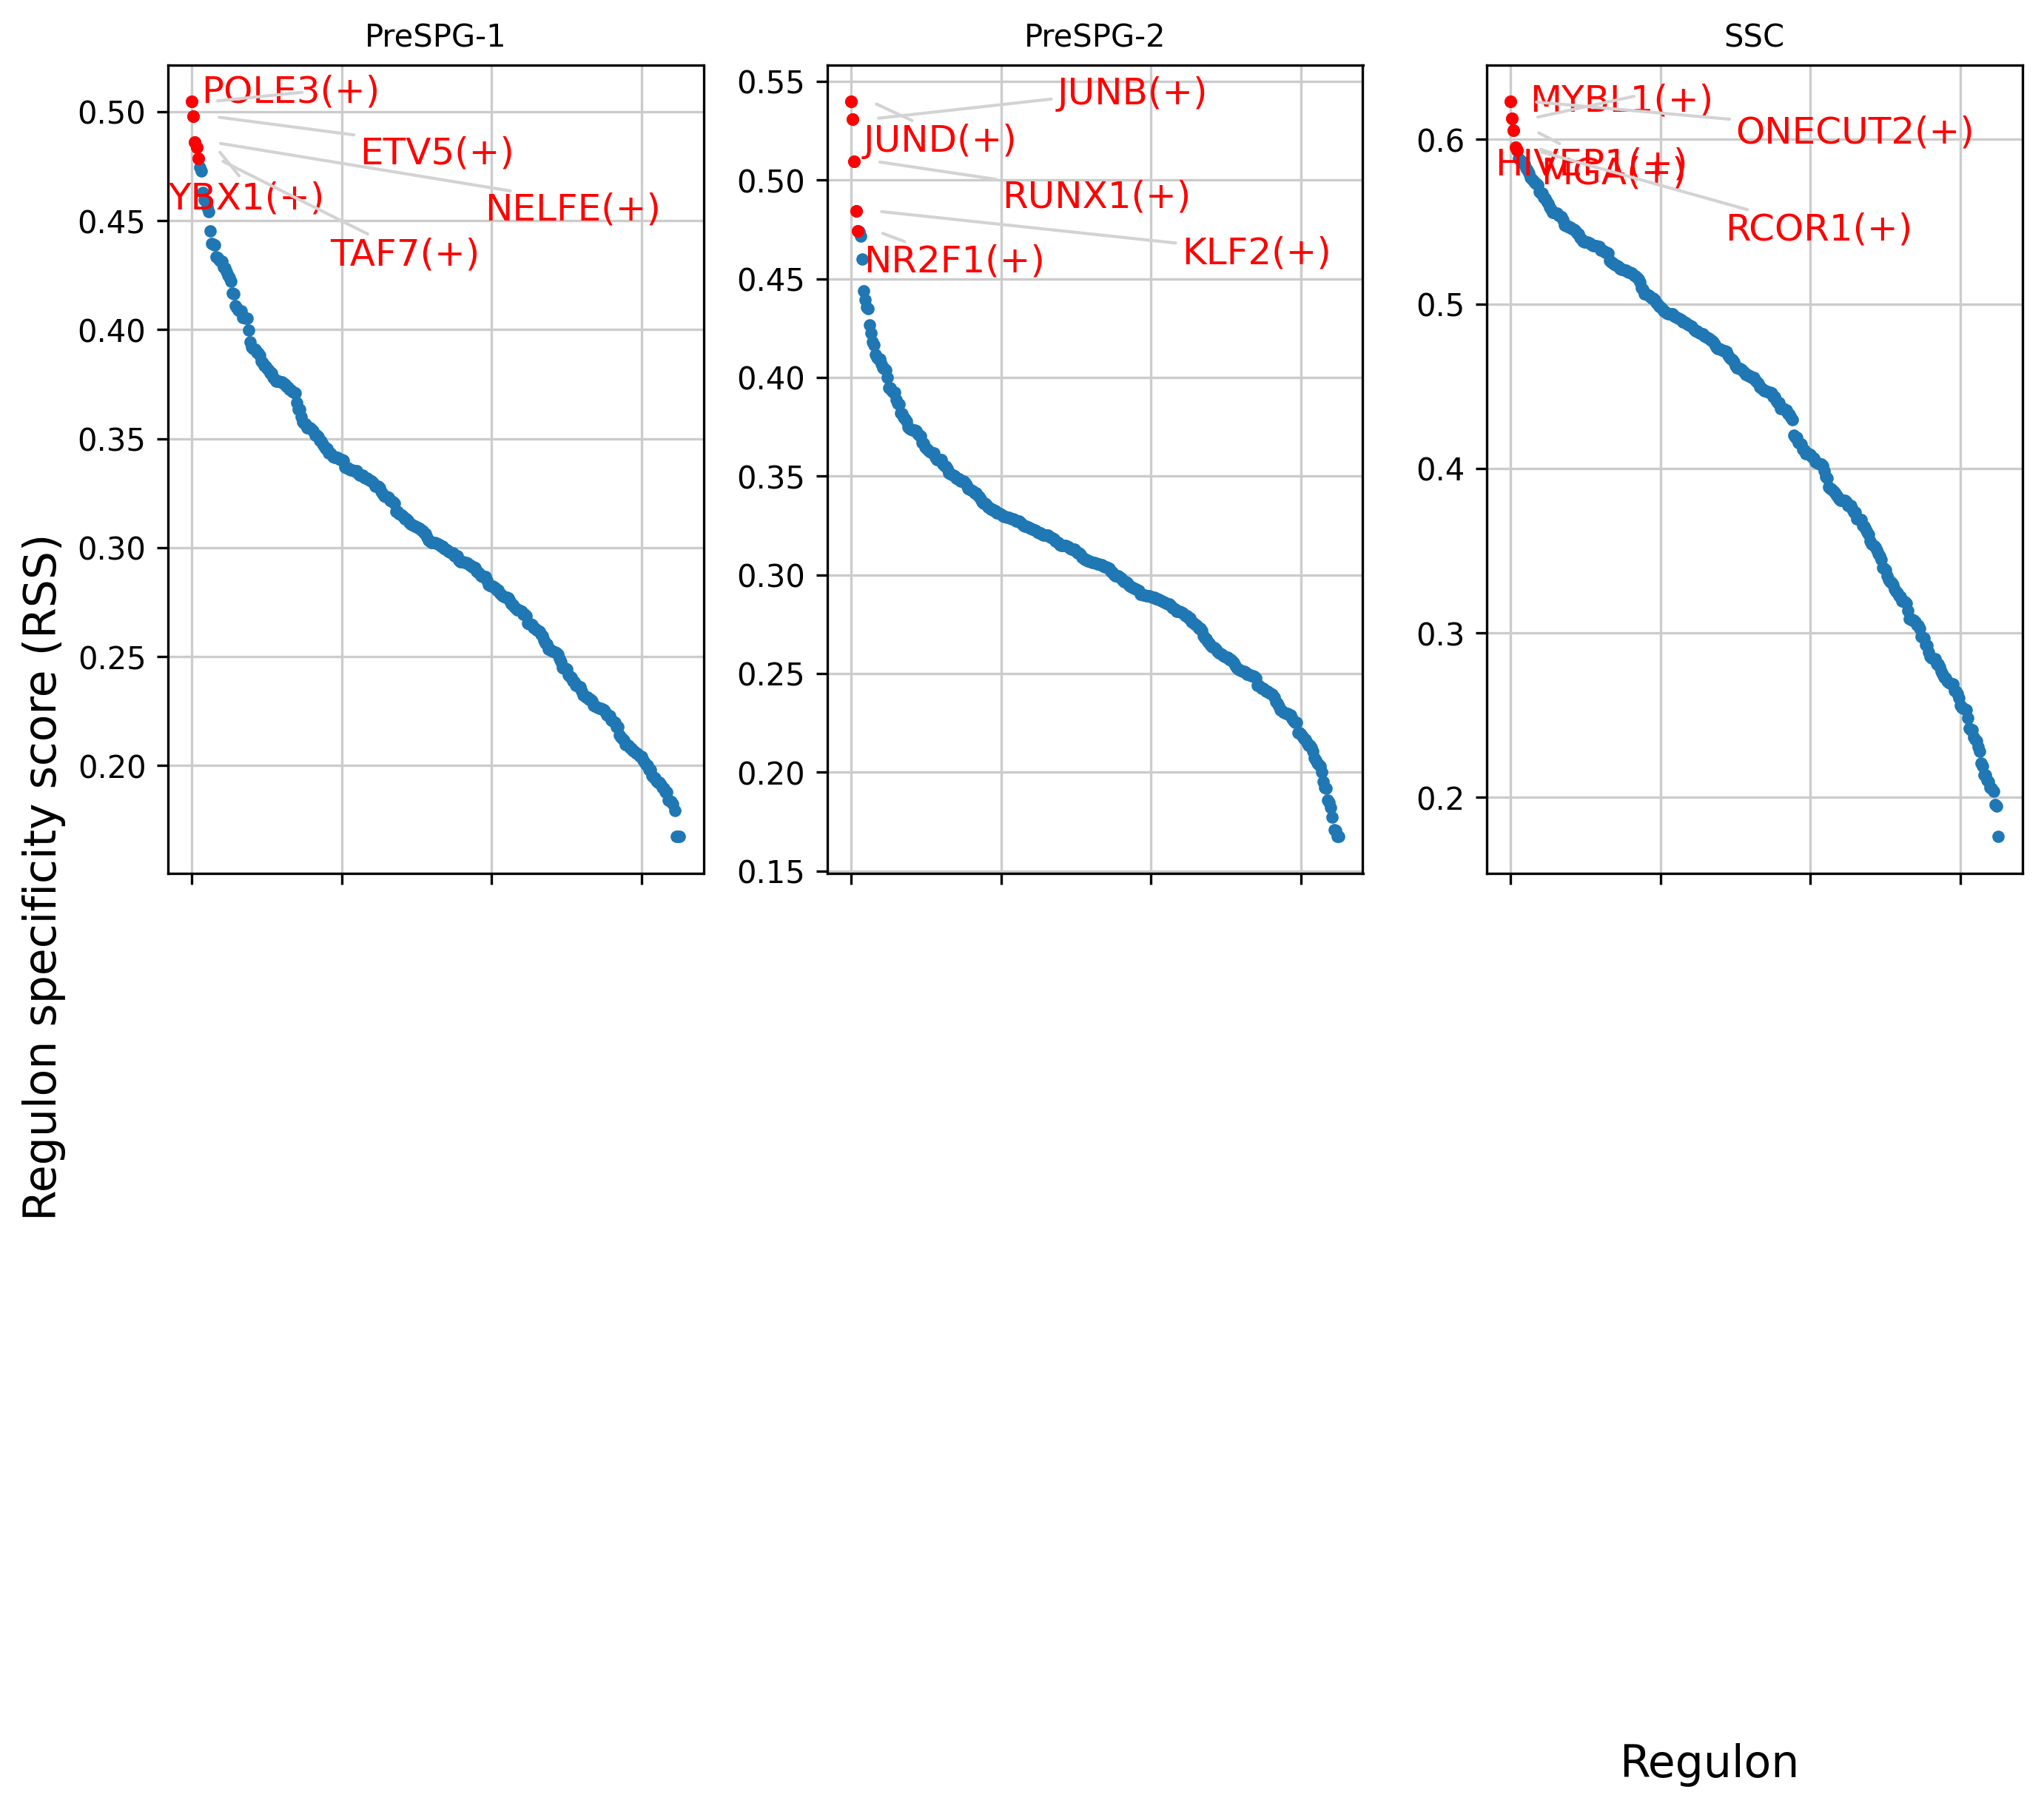

In [32]:
cats = sorted(list(set(adata.obs['cell_type'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("neospg_celltype-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [33]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:10].index)
    )
topreg = list(set(topreg))

In [34]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

/tmp/ipykernel_95470/68287874.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/tmp/ipykernel_95470/68287874.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
/tmp/ipykernel_95470/68287874.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

In [35]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [36]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in adata.obs['cell_type']]

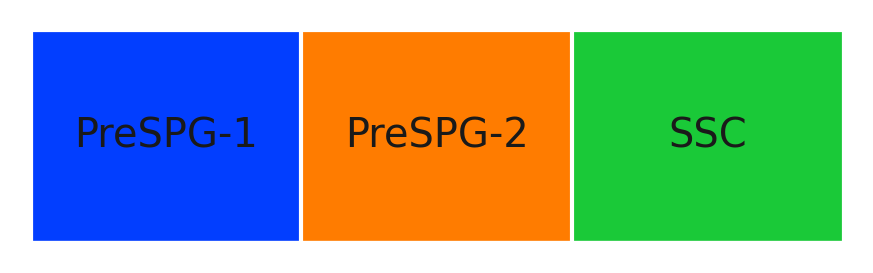

In [37]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("neospg_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

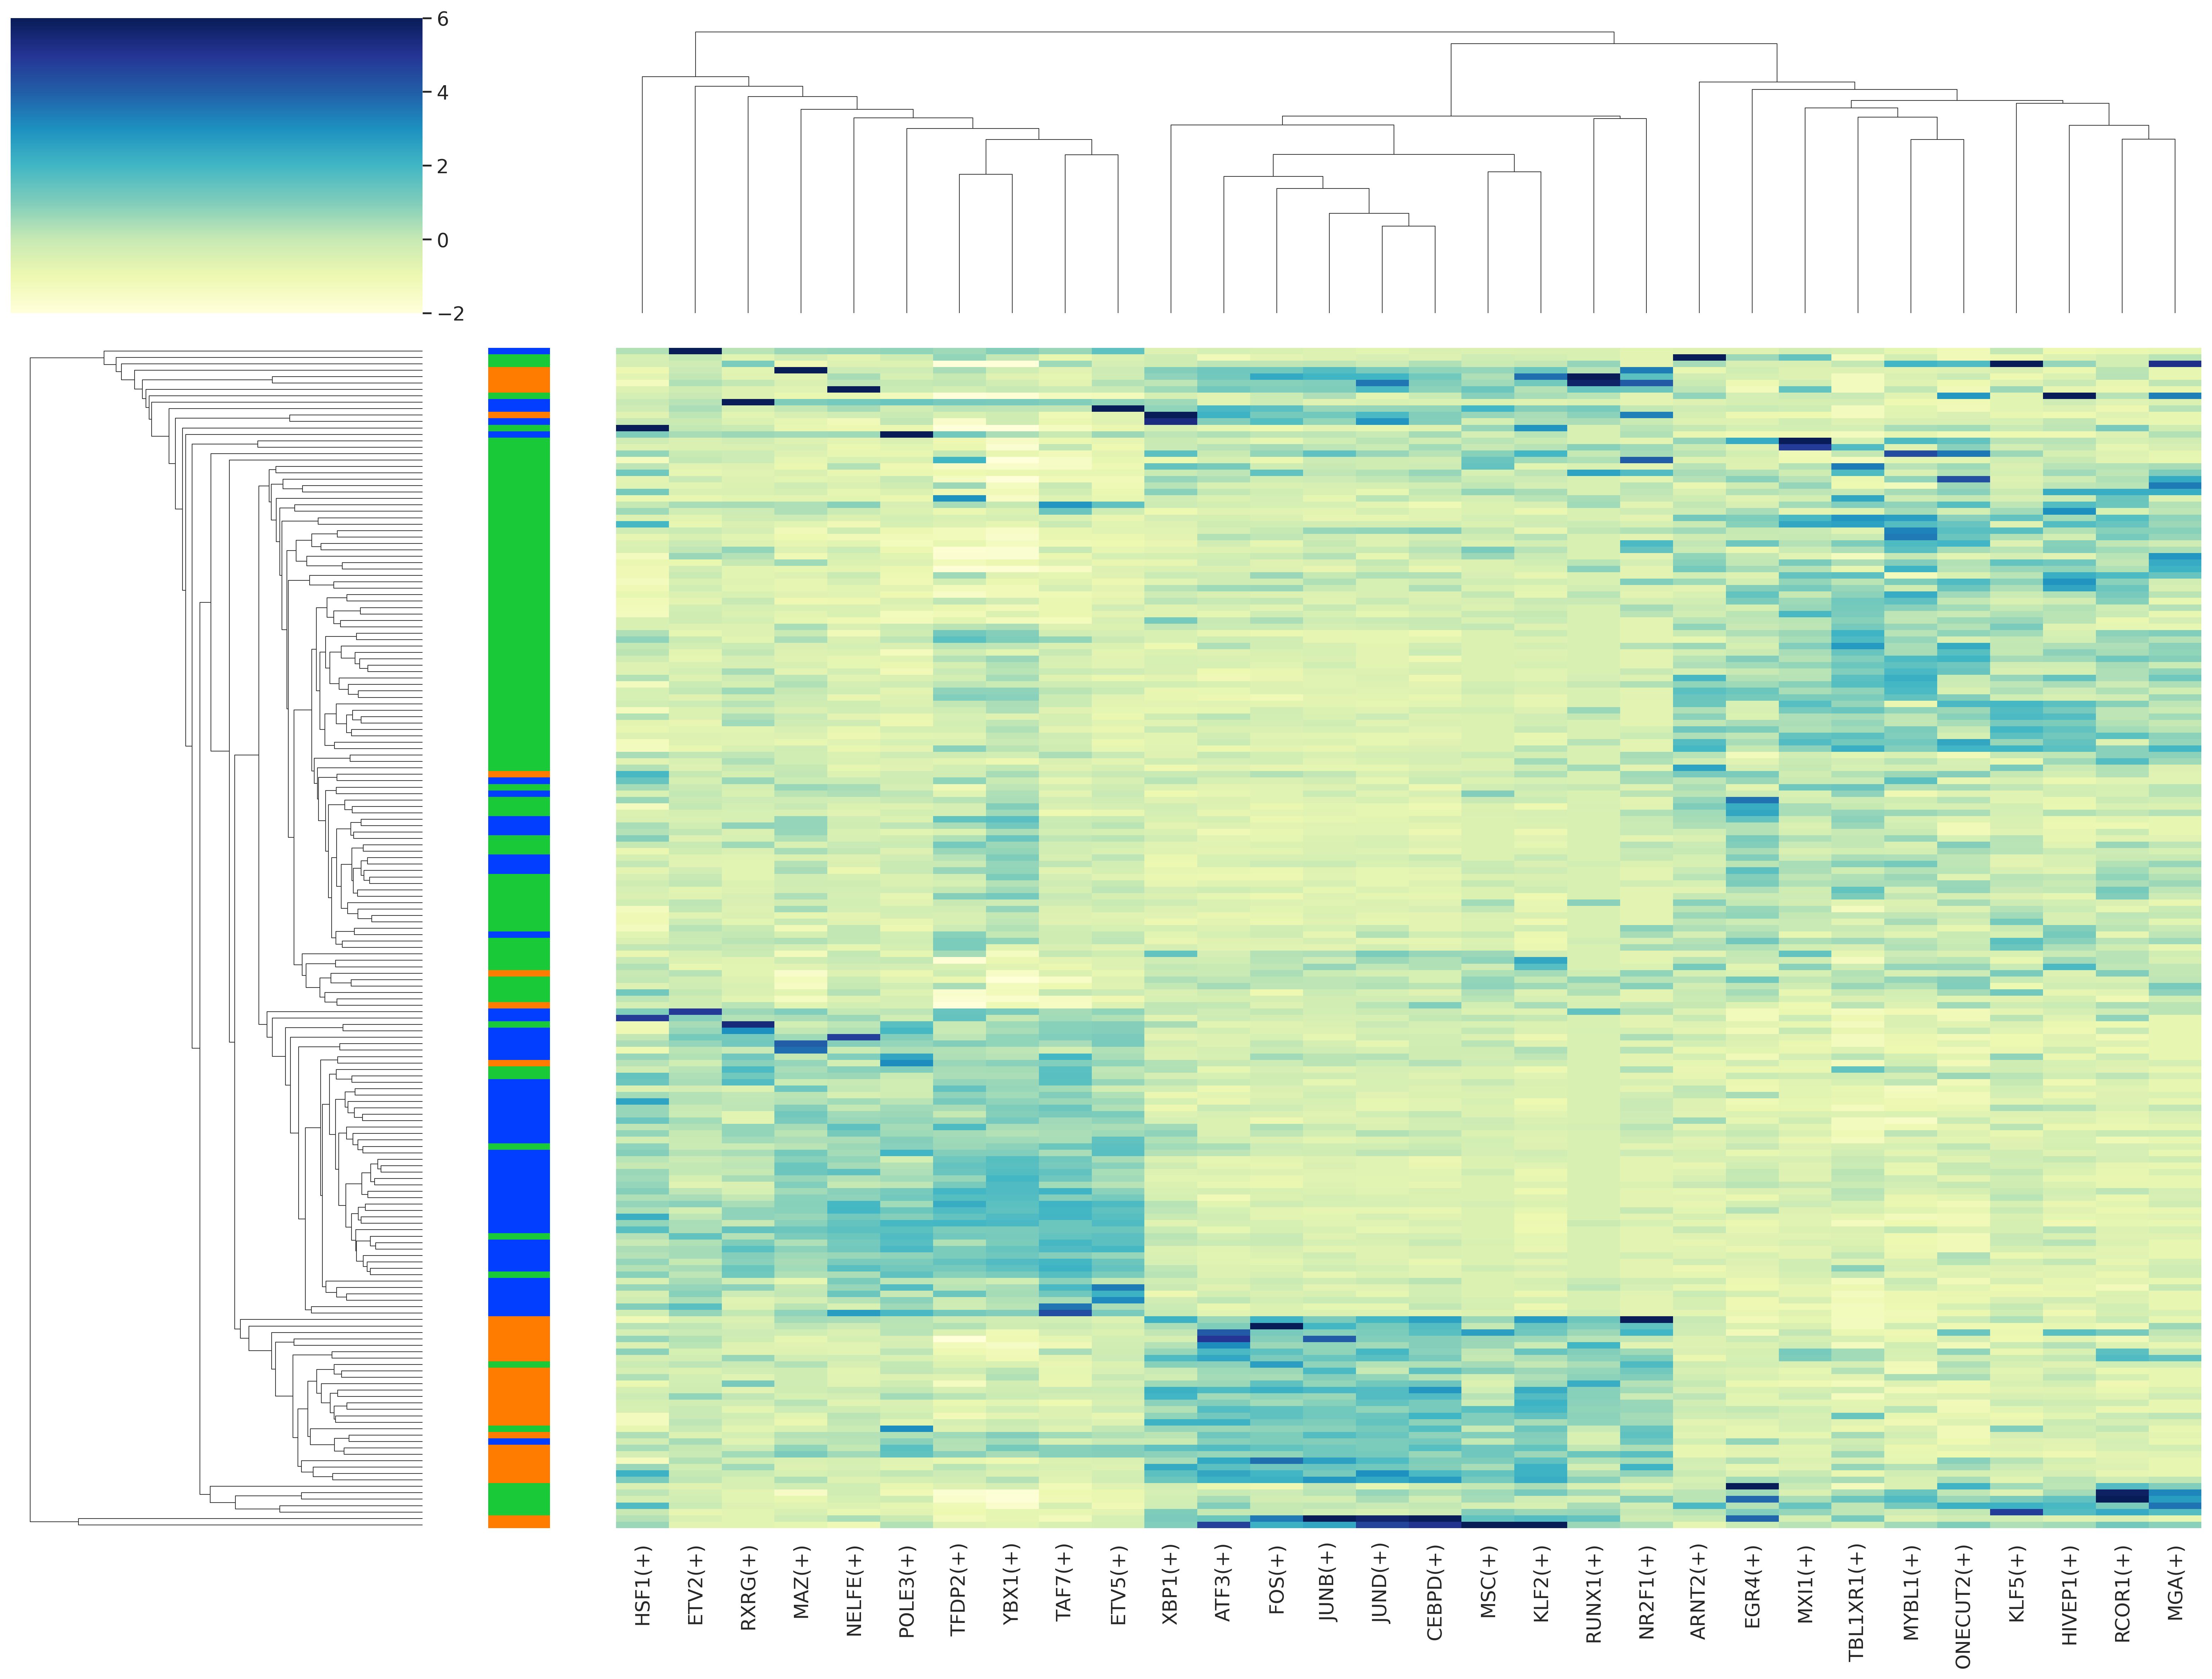

In [38]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("neospg_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

In [39]:
# helper functions (not yet integrated into pySCENIC):

from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [41]:
#display_logos(df_motifs.head())
display_logos(df_motifs.sort_values([('Enrichment','NES')], ascending=False).head(100))

/tmp/ipykernel_95470/1525678731.py:33: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', MAX_COL_WIDTH)


In [42]:
cell_type_color_lut = dict(zip(adata.obs["cell_type"].dtype.categories, adata.uns["cell_type_colors"]))
cell_id2cell_type_lut = adata.obs["cell_type"].to_dict()
bw_palette = sns.xkcd_palette(["white", "black"])

/public/home/zhaox/anaconda3/envs/pyscenic/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


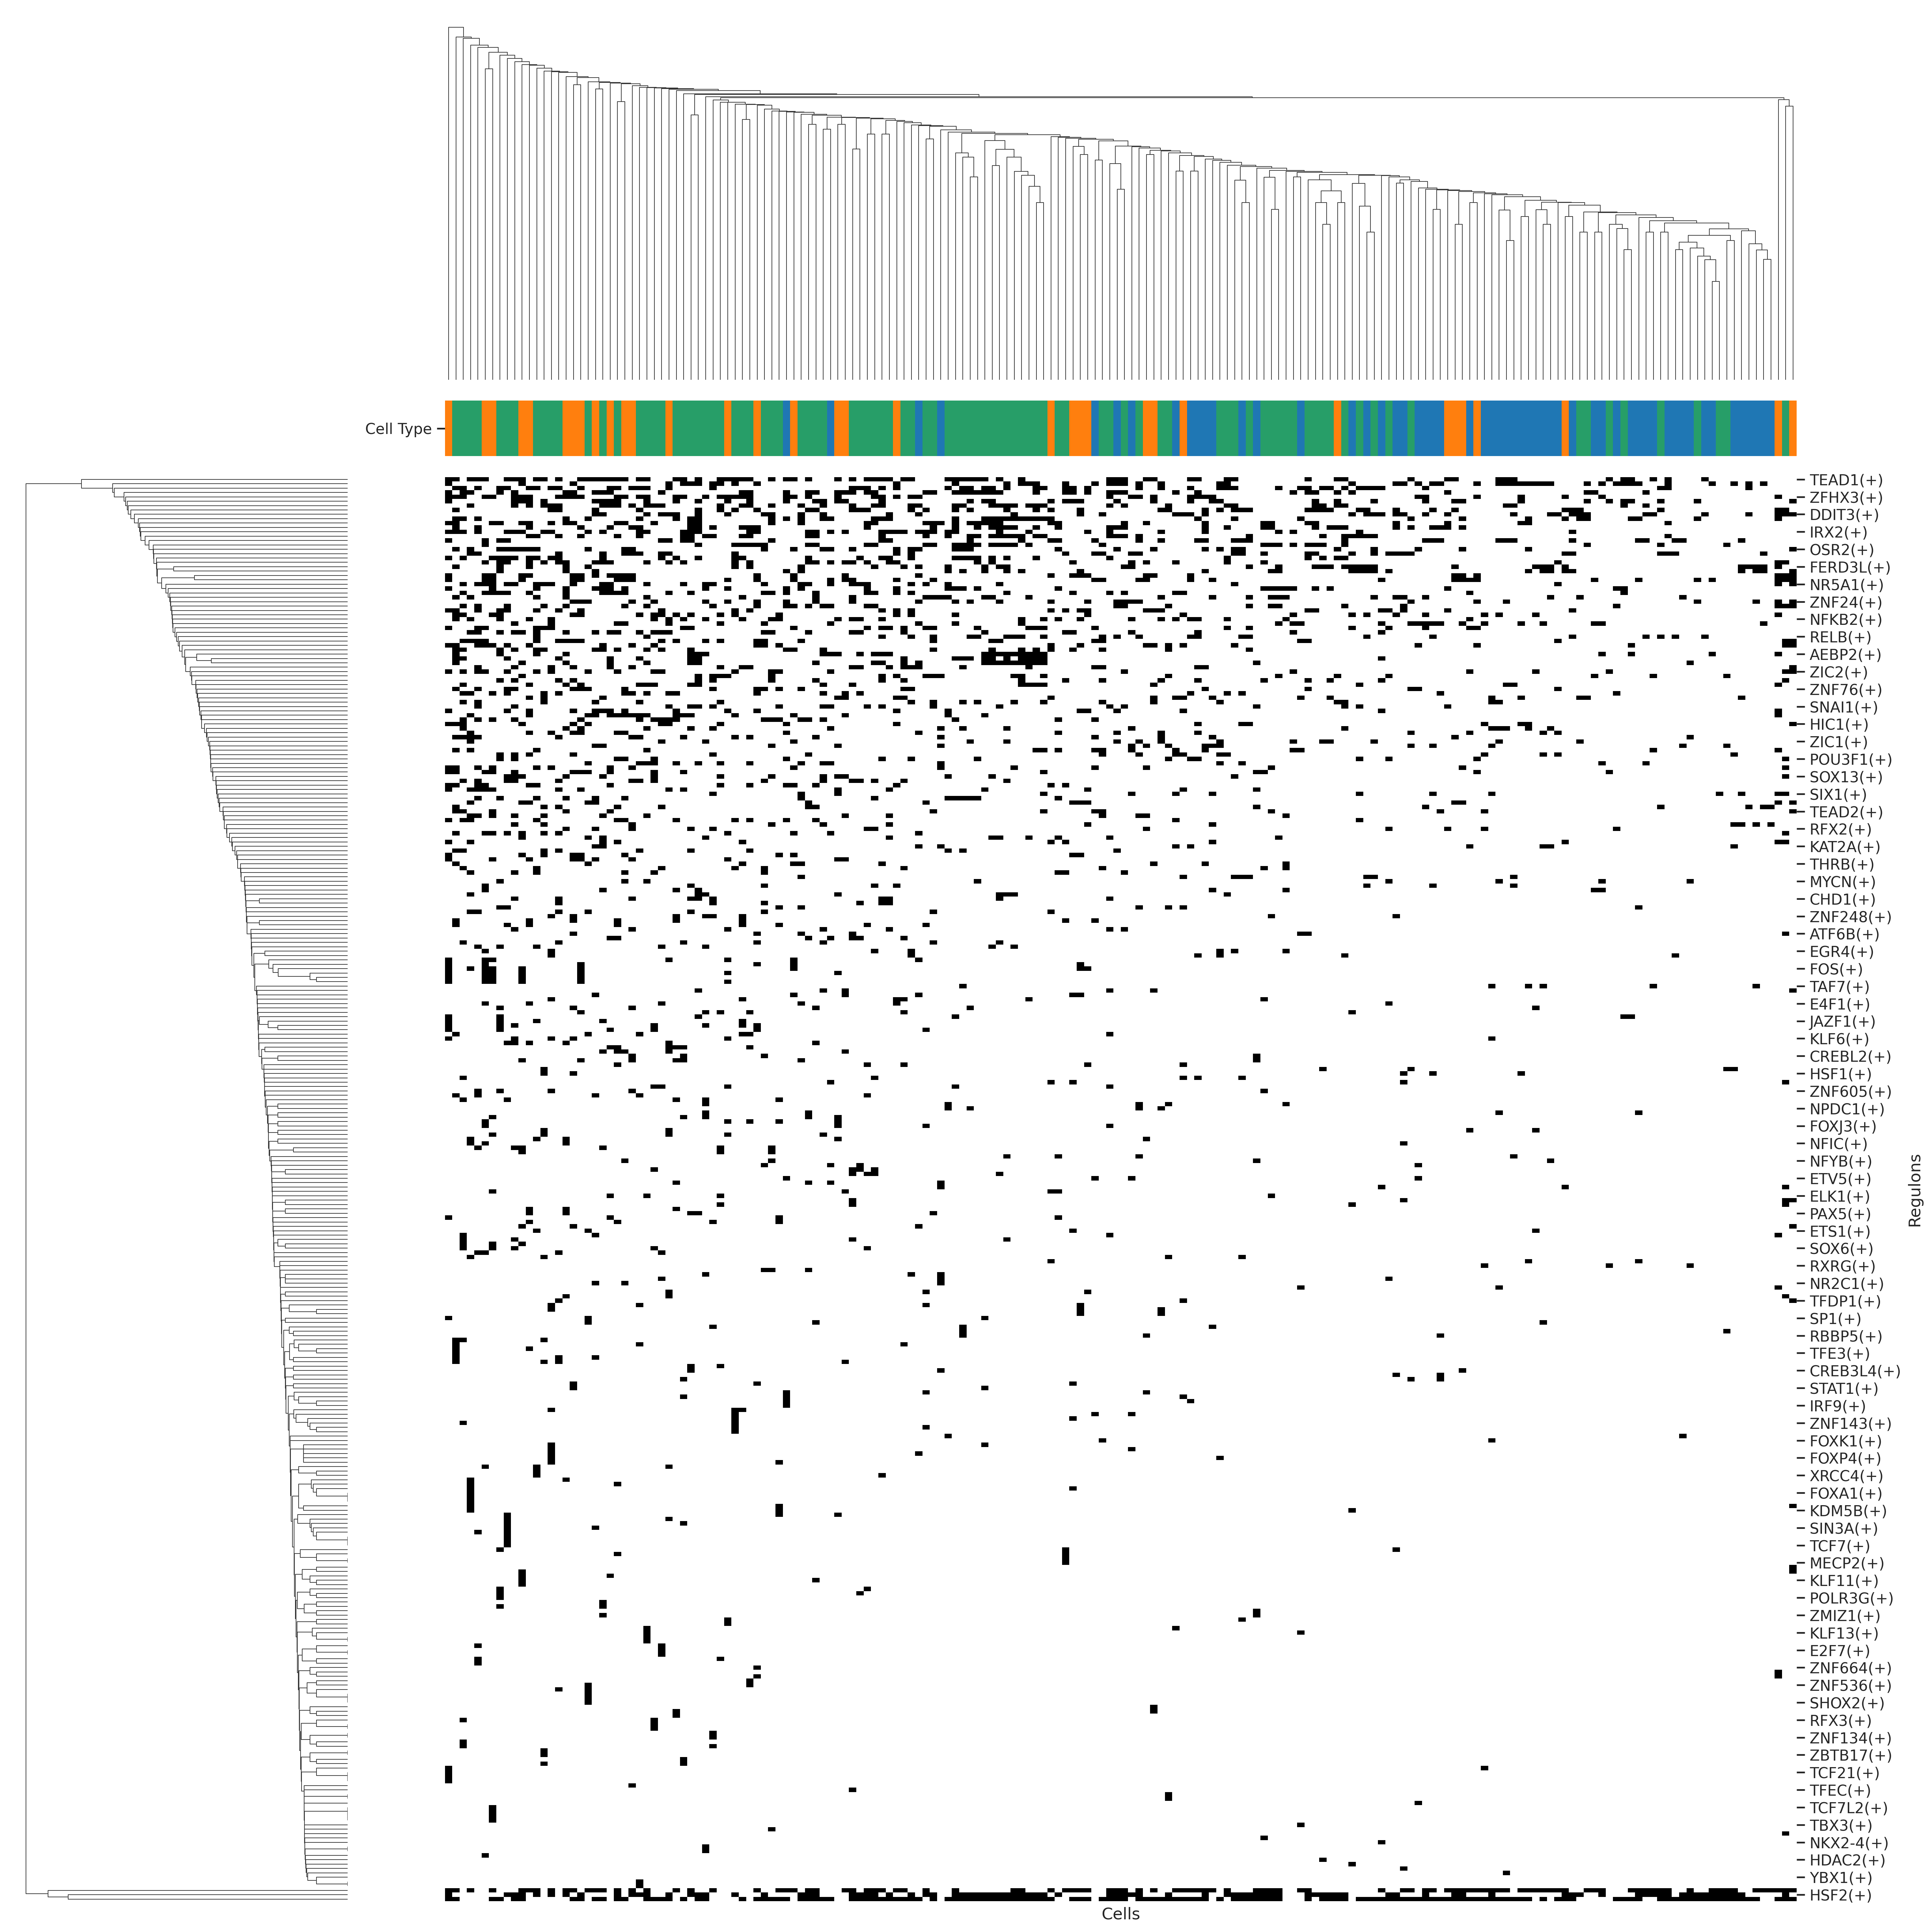

In [43]:
sns.set()
sns.set(font_scale=1.0)
sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
g = sns.clustermap(
    data=bin_mtx.T, 
    col_colors=auc_mtx.index.map(cell_id2cell_type_lut).map(cell_type_color_lut),
    cmap=bw_palette, figsize=(20,20)
    )
g.ax_heatmap.set_xticklabels([])
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_xlabel('Cells')
g.ax_heatmap.set_ylabel('Regulons')
g.ax_col_colors.set_yticks([0.5])
g.ax_col_colors.set_yticklabels(['Cell Type'])
g.cax.set_visible(False)
plt.savefig("neospg_cellType_Binaryactivity-heatmap0509.pdf", dpi=600, bbox_inches = "tight") 